In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.regression import GBTRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import datetime

spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/16 21:55:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/16 21:56:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/16 21:56:00 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/16 21:56:00 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


<h2>Aim: Determine a model for predicting revenue in the future. </h2>

<h2>1. Data preprocessing</h2>

<h3>1.1 Feature Selection: discard all external features since their high correlation to each other. </h3>

In [2]:
sdf = spark.read.parquet('../data/curated/merchant_consumer_abs')
sdf = sdf.drop(*['postcode', 'products', 'take_rate', 'category', 'fraud_group',
                 'user_id', 'consumer', 'consumer_address', 'consumer_state', 'consumer_postcode', 'order_day',
                 '__index_level_0__'])
for i in sdf.columns[:7]:
    if i != "median_age":
        sdf = sdf.drop(i)
# for i in sdf.columns[:4]:
#     sdf = sdf.withColumn(f"log_{i}", when(log(col(i)) > 0, log(col(i))).otherwise(0)).drop(i).withColumnRenamed(f"log_{i}", i)
# sdf = sdf.select(*(sdf.columns[-4:]), *(sdf.columns[:-4]))
sdf

median_age,persons/km2,merchant_name,revenue_level,order_datetime,tag,dollar_value,order_year,order_month,consumer_gender
33.00000004463053,2419.9999940679677,Elit Sed Consequa...,a,2022-04-27,artist supply craft,375.16773164703153,2022,4,Female
33.00000004463053,2419.9999940679677,Elit Sed Consequa...,a,2022-10-07,artist supply craft,617.8791313462011,2022,10,Male
33.00000004463053,2419.9999940679677,Elit Sed Consequa...,a,2022-02-28,artist supply craft,766.5077067424303,2022,2,Female
33.00000004463053,2419.9999940679677,Malesuada Vel Ltd,b,2021-07-24,books periodicals...,258.86595899218753,2021,7,Female
33.00000004463053,2419.9999940679677,Varius Orci Insti...,a,2021-08-08,tent awning,4.159037931172075,2021,8,Female
33.00000004463053,2419.9999940679677,Volutpat Nulla In...,a,2022-10-11,furniture home fu...,8.26105405068297,2022,10,Male
33.00000004463053,2419.9999940679677,Mollis Integer Co...,b,2022-05-02,digital goods boo...,83.63154755239155,2022,5,Female
33.00000004463053,2419.9999940679677,Elit Sed Consequa...,a,2021-04-08,artist supply craft,87.00495112586256,2021,4,Female
33.00000004463053,2419.9999940679677,Eros Limited,c,2021-12-18,digital goods boo...,8.26187754879106,2021,12,Female
33.00000004463053,2419.9999940679677,Hendrerit A Corpo...,a,2022-07-14,watch clock jewel...,100.80643267043831,2022,7,Male


In [3]:
graph = pd.read_parquet('../data/curated/merchant_consumer_abs')

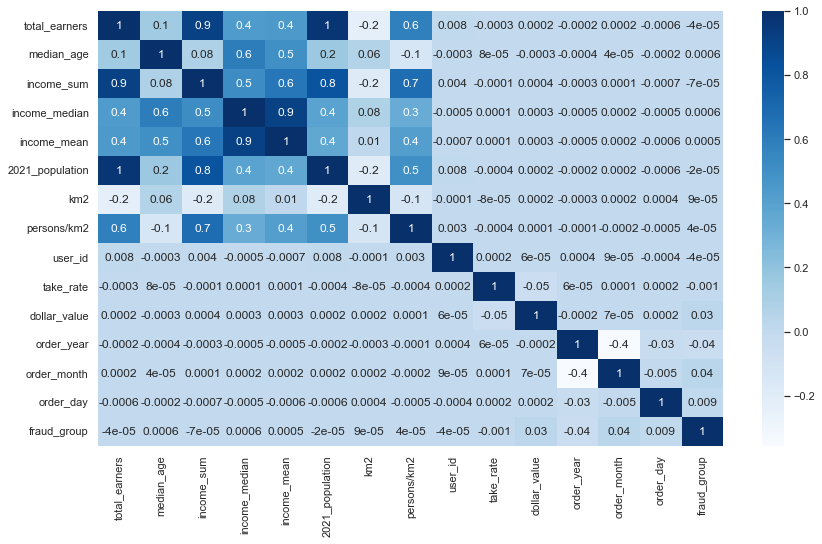

In [4]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = graph.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

heatmap.get_figure().savefig("../plots/corr.png")

<h3>1.2 Feature Interaction: consider the interaction between some features. </h3>

In [5]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Interaction

interact = ["tag", "revenue_level", "order_month", "order_year"]
for i in interact:
    stringIndexer = StringIndexer(inputCol=i, outputCol=f"{i}_num")
    sdf = stringIndexer.fit(sdf).transform(sdf).drop(i)
    encoder = OneHotEncoder(inputCol=f"{i}_num", outputCol=i+"_vec")
    sdf = encoder.fit(sdf).transform(sdf).drop(f"{i}_num")

interaction = Interaction(inputCols=[f"{i}_vec" for i in interact], outputCol="interact")
sdf = interaction.transform(sdf)

<h3>1.3 Vectorize the categorical feature (gender). </h3>

In [6]:
genders = sdf.select("consumer_gender").distinct().rdd.flatMap(lambda x: x).collect()
exprs = [when(col("consumer_gender") == category, 1).otherwise(0).alias(category)
         for category in genders]
sdf = sdf.select(*(sdf.columns), *exprs).drop("consumer_gender")

<h3>1.4 Split data (ratio of 0.2). </h3>

In [7]:
train = sdf.where((col("order_datetime") <= "2022-07-31")).where((col("order_datetime") > "2022-02-28")).drop("order_datetime")
test = sdf.where((col("order_datetime") > "2022-07-31")).drop("order_datetime")

<h3>1.5 Aggregate data based on merchants. </h3>

In [8]:
train_agg = train
w = Window.partitionBy('merchant_name')
train_agg = train_agg.withColumn("avg(median_age)", avg("median_age").over(w)).drop("median_age")

In [9]:
agg_cols = train_agg.columns
for i in ["dollar_value", "Female", "Male", "Undisclosed"]:
    agg_cols.remove(i)
train_agg = train_agg.groupBy(agg_cols).agg(sum("dollar_value"), sum("Female"), sum("Male"), sum("Undisclosed"))
w = Window.partitionBy("merchant_name")
for i in ["Female", "Male", "Undisclosed"]:
    train_agg = train_agg.withColumn(f"avg({i.lower()})", avg(f"sum({i})").over(w)).drop(f"sum({i})")
train_agg = train_agg.withColumnRenamed("sum(dollar_value)", "dollar_value")

In [10]:
test_agg = test.groupBy(train_agg.columns[:5]).agg(sum("dollar_value").alias("dollar_value"))
train_agg.columns[5:]
merch_agg = train_agg.select(col("merchant_name").alias("merchant_name_copy"), *(train_agg.columns[5:])).drop("dollar_value").distinct()
test_agg = test_agg.join(merch_agg, test_agg.merchant_name == merch_agg.merchant_name_copy, "left").drop("merchant_name_copy")
test_agg

persons/km2,merchant_name,tag_vec,revenue_level_vec,order_month_vec,dollar_value,order_year_vec,interact,avg(median_age),avg(female),avg(male),avg(undisclosed)
554.1509663972762,Adipiscing Enim LLC,"(24,[2],[1.0])","(4,[0],[1.0])","(11,[1],[1.0])",47.14608934153825,"(1,[0],[1.0])","(1056,[93],[1.0])",42.30835807332568,0.5612215499855949,0.5859982713915298,0.1264765197349467
554.1509663972762,Adipiscing Enim LLC,"(24,[2],[1.0])","(4,[0],[1.0])","(11,[1],[1.0])",47.14608934153825,"(1,[0],[1.0])","(1056,[92],[1.0])",42.30835807332568,0.5612215499855949,0.5859982713915298,0.1264765197349467
554.1509663972762,Adipiscing Enim LLC,"(24,[2],[1.0])","(4,[0],[1.0])","(11,[1],[1.0])",47.14608934153825,"(1,[0],[1.0])","(1056,[91],[1.0])",42.30835807332568,0.5612215499855949,0.5859982713915298,0.1264765197349467
554.1509663972762,Adipiscing Enim LLC,"(24,[2],[1.0])","(4,[0],[1.0])","(11,[1],[1.0])",47.14608934153825,"(1,[0],[1.0])","(1056,[94],[1.0])",42.30835807332568,0.5612215499855949,0.5859982713915298,0.1264765197349467
554.1509663972762,Adipiscing Enim LLC,"(24,[2],[1.0])","(4,[0],[1.0])","(11,[1],[1.0])",47.14608934153825,"(1,[0],[1.0])","(1056,[95],[1.0])",42.30835807332568,0.5612215499855949,0.5859982713915298,0.1264765197349467
541.6573730991709,Adipiscing Enim LLC,"(24,[2],[1.0])","(4,[0],[1.0])","(11,[2],[1.0])",7.790893751110889,"(1,[0],[1.0])","(1056,[93],[1.0])",42.30835807332568,0.5612215499855949,0.5859982713915298,0.1264765197349467
541.6573730991709,Adipiscing Enim LLC,"(24,[2],[1.0])","(4,[0],[1.0])","(11,[2],[1.0])",7.790893751110889,"(1,[0],[1.0])","(1056,[92],[1.0])",42.30835807332568,0.5612215499855949,0.5859982713915298,0.1264765197349467
541.6573730991709,Adipiscing Enim LLC,"(24,[2],[1.0])","(4,[0],[1.0])","(11,[2],[1.0])",7.790893751110889,"(1,[0],[1.0])","(1056,[91],[1.0])",42.30835807332568,0.5612215499855949,0.5859982713915298,0.1264765197349467
541.6573730991709,Adipiscing Enim LLC,"(24,[2],[1.0])","(4,[0],[1.0])","(11,[2],[1.0])",7.790893751110889,"(1,[0],[1.0])","(1056,[94],[1.0])",42.30835807332568,0.5612215499855949,0.5859982713915298,0.1264765197349467
541.6573730991709,Adipiscing Enim LLC,"(24,[2],[1.0])","(4,[0],[1.0])","(11,[2],[1.0])",7.790893751110889,"(1,[0],[1.0])","(1056,[95],[1.0])",42.30835807332568,0.5612215499855949,0.5859982713915298,0.1264765197349467


<h2>2. Train and evaluate models. </h2>

In [11]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

feats = train_agg.columns
feats.remove('merchant_name')
feats.remove('dollar_value')
assembler = VectorAssembler(inputCols=feats, outputCol="features")
train_vec = assembler.transform(train_agg)
test_vec = assembler.transform(test_agg)

<h3>2.1 Linear Regression </h3>

In [12]:
from pyspark.ml.regression import LinearRegression

# fit lr model

train_lm = train_vec.select("features", col("dollar_value").alias("label"))
test_lm = train_vec.select("features", col("dollar_value").alias("label"))

lr = LinearRegression()
lm = lr.fit(train_lm)

22/10/16 21:57:23 WARN Instrumentation: [a59aa3a0] regParam is zero, which might cause numerical instability and overfitting.


22/10/16 21:57:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/16 21:57:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/10/16 21:57:27 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
22/10/16 21:57:27 WARN Instrumentation: [a59aa3a0] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
22/10/16 21:57:28 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/16 21:57:28 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [13]:
lm_predict = lm.transform(test_lm)

In [14]:
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(labelCol="label",
                                    predictionCol="prediction",
                                    metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="label",
                                   predictionCol="prediction",
                                   metricName="r2")
rmse = rmse_evaluator.evaluate(lm_predict)
print("Root Mean Squared Error (RMSE) = %g" % rmse)
r2 = r2_evaluator.evaluate(lm_predict)
print("R Squared (R2) = %g" % r2)

Root Mean Squared Error (RMSE) = 228.585


R Squared (R2) = 0.163105


In [15]:
lm_predict

features,label,prediction
"(1101,[0,7,26,36,...",201.08786837396272,113.73483390205325
"(1101,[0,7,26,32,...",347.86377381210417,122.17780820617895
"(1101,[0,7,26,35,...",534.6800084579394,118.097585727065
"(1101,[0,7,26,36,...",85.43466554412305,116.15202567417185
"(1101,[0,7,26,35,...",399.4625577204659,116.91652916031097
"(1101,[0,7,26,34,...",108.53869793757973,118.1755607823278
"(1101,[0,7,26,36,...",749.2584835936165,115.9591659330967
"(1101,[0,7,26,33,...",346.0760144246462,120.56531740138553
"(1101,[0,7,26,36,...",654.2949609884379,116.09570132526164
"(1101,[0,7,26,32,...",442.5661527554534,122.17790572864163


<h3>2.2 Decision Tree Regressor </h3>

In [17]:
from pyspark.ml.regression import DecisionTreeRegressor

DTR = DecisionTreeRegressor(featuresCol="features")
dt = DTR.fit(train_lm)

22/10/16 22:00:27 WARN MemoryStore: Not enough space to cache rdd_254_2 in memory! (computed 154.4 MiB so far)
22/10/16 22:00:27 WARN BlockManager: Persisting block rdd_254_2 to disk instead.
22/10/16 22:00:27 WARN MemoryStore: Not enough space to cache rdd_254_5 in memory! (computed 99.5 MiB so far)
22/10/16 22:00:27 WARN BlockManager: Persisting block rdd_254_5 to disk instead.
22/10/16 22:00:27 WARN MemoryStore: Not enough space to cache rdd_254_6 in memory! (computed 99.5 MiB so far)
22/10/16 22:00:27 WARN BlockManager: Persisting block rdd_254_6 to disk instead.
22/10/16 22:00:29 WARN MemoryStore: Not enough space to cache rdd_254_4 in memory! (computed 99.5 MiB so far)
22/10/16 22:00:29 WARN BlockManager: Persisting block rdd_254_4 to disk instead.
22/10/16 22:00:29 WARN MemoryStore: Not enough space to cache rdd_254_7 in memory! (computed 99.5 MiB so far)
22/10/16 22:00:29 WARN BlockManager: Persisting block rdd_254_7 to disk instead.
22/10/16 22:00:36 WARN MemoryStore: Not enou

22/10/16 22:00:50 WARN MemoryStore: Not enough space to cache rdd_254_7 in memory! (computed 155.0 MiB so far)
22/10/16 22:00:51 WARN MemoryStore: Not enough space to cache rdd_254_5 in memory! (computed 237.0 MiB so far)
22/10/16 22:00:51 WARN MemoryStore: Not enough space to cache rdd_254_2 in memory! (computed 237.0 MiB so far)
22/10/16 22:00:51 WARN MemoryStore: Not enough space to cache rdd_254_3 in memory! (computed 237.0 MiB so far)
22/10/16 22:00:51 WARN MemoryStore: Not enough space to cache rdd_254_6 in memory! (computed 237.0 MiB so far)
22/10/16 22:00:51 WARN MemoryStore: Not enough space to cache rdd_254_4 in memory! (computed 237.0 MiB so far)
22/10/16 22:00:51 WARN MemoryStore: Not enough space to cache rdd_254_1 in memory! (computed 237.0 MiB so far)
22/10/16 22:00:54 WARN MemoryStore: Not enough space to cache rdd_254_0 in memory! (computed 1242.6 MiB so far)


22/10/16 22:00:56 WARN MemoryStore: Not enough space to cache rdd_254_7 in memory! (computed 155.0 MiB so far)
22/10/16 22:00:57 WARN MemoryStore: Not enough space to cache rdd_254_2 in memory! (computed 237.0 MiB so far)
22/10/16 22:00:57 WARN MemoryStore: Not enough space to cache rdd_254_1 in memory! (computed 237.0 MiB so far)
22/10/16 22:00:57 WARN MemoryStore: Not enough space to cache rdd_254_3 in memory! (computed 237.0 MiB so far)
22/10/16 22:00:57 WARN MemoryStore: Not enough space to cache rdd_254_6 in memory! (computed 237.0 MiB so far)
22/10/16 22:00:57 WARN MemoryStore: Not enough space to cache rdd_254_0 in memory! (computed 237.0 MiB so far)
22/10/16 22:00:57 WARN MemoryStore: Not enough space to cache rdd_254_5 in memory! (computed 237.0 MiB so far)
22/10/16 22:01:00 WARN MemoryStore: Not enough space to cache rdd_254_4 in memory! (computed 1242.6 MiB so far)


22/10/16 22:01:02 WARN MemoryStore: Not enough space to cache rdd_254_1 in memory! (computed 155.0 MiB so far)
22/10/16 22:01:03 WARN MemoryStore: Not enough space to cache rdd_254_3 in memory! (computed 237.0 MiB so far)
22/10/16 22:01:03 WARN MemoryStore: Not enough space to cache rdd_254_2 in memory! (computed 237.0 MiB so far)
22/10/16 22:01:03 WARN MemoryStore: Not enough space to cache rdd_254_0 in memory! (computed 237.0 MiB so far)
22/10/16 22:01:03 WARN MemoryStore: Not enough space to cache rdd_254_6 in memory! (computed 237.0 MiB so far)
22/10/16 22:01:03 WARN MemoryStore: Not enough space to cache rdd_254_4 in memory! (computed 237.0 MiB so far)
22/10/16 22:01:03 WARN MemoryStore: Not enough space to cache rdd_254_7 in memory! (computed 237.0 MiB so far)


22/10/16 22:01:07 WARN MemoryStore: Not enough space to cache rdd_254_2 in memory! (computed 100.0 MiB so far)
22/10/16 22:01:07 WARN MemoryStore: Not enough space to cache rdd_254_3 in memory! (computed 100.0 MiB so far)
22/10/16 22:01:07 WARN MemoryStore: Not enough space to cache rdd_254_0 in memory! (computed 100.0 MiB so far)
22/10/16 22:01:07 WARN MemoryStore: Not enough space to cache rdd_254_6 in memory! (computed 100.0 MiB so far)
22/10/16 22:01:07 WARN MemoryStore: Not enough space to cache rdd_254_7 in memory! (computed 100.0 MiB so far)
22/10/16 22:01:07 WARN MemoryStore: Not enough space to cache rdd_254_1 in memory! (computed 100.0 MiB so far)
22/10/16 22:01:07 WARN MemoryStore: Not enough space to cache rdd_254_4 in memory! (computed 100.0 MiB so far)


In [18]:
dt_predict = dt.transform(test_lm)

In [19]:
print("Root Mean Squared Error (RMSE) = %g" % rmse_evaluator.evaluate(dt_predict))
print("R Squared (R2) = %g" % r2_evaluator.evaluate(dt_predict))

Root Mean Squared Error (RMSE) = 233.41


R Squared (R2) = 0.127407


<h3>2.3 Random Forest Regressor </h3>

In [20]:
from pyspark.ml.regression import RandomForestRegressor

RFR = RandomForestRegressor(featuresCol="features")
rf = RFR.fit(train_lm)
rf_predict = rf.transform(test_lm)
print("Root Mean Squared Error (RMSE) = %g" % rmse_evaluator.evaluate(rf_predict))
print("R Squared (R2) = %g" % r2_evaluator.evaluate(rf_predict))

22/10/16 22:02:24 WARN MemoryStore: Not enough space to cache rdd_330_7 in memory! (computed 67.2 MiB so far)
22/10/16 22:02:24 WARN BlockManager: Persisting block rdd_330_7 to disk instead.
22/10/16 22:02:24 WARN MemoryStore: Not enough space to cache rdd_330_2 in memory! (computed 101.7 MiB so far)
22/10/16 22:02:24 WARN BlockManager: Persisting block rdd_330_2 to disk instead.
22/10/16 22:02:24 WARN MemoryStore: Not enough space to cache rdd_330_1 in memory! (computed 67.2 MiB so far)
22/10/16 22:02:24 WARN BlockManager: Persisting block rdd_330_1 to disk instead.
22/10/16 22:02:24 WARN MemoryStore: Not enough space to cache rdd_330_3 in memory! (computed 157.7 MiB so far)
22/10/16 22:02:24 WARN BlockManager: Persisting block rdd_330_3 to disk instead.
22/10/16 22:02:24 WARN MemoryStore: Not enough space to cache rdd_330_4 in memory! (computed 101.7 MiB so far)
22/10/16 22:02:24 WARN BlockManager: Persisting block rdd_330_4 to disk instead.
22/10/16 22:02:24 WARN MemoryStore: Not en

22/10/16 22:02:54 WARN MemoryStore: Not enough space to cache rdd_330_1 in memory! (computed 157.7 MiB so far)
22/10/16 22:02:54 WARN MemoryStore: Not enough space to cache rdd_330_7 in memory! (computed 157.7 MiB so far)
22/10/16 22:02:54 WARN MemoryStore: Not enough space to cache rdd_330_6 in memory! (computed 240.8 MiB so far)
22/10/16 22:02:54 WARN MemoryStore: Not enough space to cache rdd_330_5 in memory! (computed 240.8 MiB so far)
22/10/16 22:02:54 WARN MemoryStore: Not enough space to cache rdd_330_3 in memory! (computed 240.8 MiB so far)
22/10/16 22:02:54 WARN MemoryStore: Not enough space to cache rdd_330_2 in memory! (computed 240.8 MiB so far)
22/10/16 22:02:54 WARN MemoryStore: Not enough space to cache rdd_330_0 in memory! (computed 240.8 MiB so far)
22/10/16 22:02:54 WARN MemoryStore: Not enough space to cache rdd_330_4 in memory! (computed 240.8 MiB so far)


22/10/16 22:03:05 WARN MemoryStore: Not enough space to cache rdd_330_6 in memory! (computed 157.7 MiB so far)
22/10/16 22:03:05 WARN MemoryStore: Not enough space to cache rdd_330_2 in memory! (computed 157.7 MiB so far)
22/10/16 22:03:05 WARN MemoryStore: Not enough space to cache rdd_330_4 in memory! (computed 240.8 MiB so far)
22/10/16 22:03:05 WARN MemoryStore: Not enough space to cache rdd_330_3 in memory! (computed 240.8 MiB so far)
22/10/16 22:03:05 WARN MemoryStore: Not enough space to cache rdd_330_5 in memory! (computed 240.8 MiB so far)
22/10/16 22:03:05 WARN MemoryStore: Not enough space to cache rdd_330_0 in memory! (computed 240.8 MiB so far)
22/10/16 22:03:05 WARN MemoryStore: Not enough space to cache rdd_330_7 in memory! (computed 240.8 MiB so far)
22/10/16 22:03:05 WARN MemoryStore: Not enough space to cache rdd_330_1 in memory! (computed 240.8 MiB so far)


22/10/16 22:03:16 WARN MemoryStore: Not enough space to cache rdd_330_4 in memory! (computed 157.7 MiB so far)
22/10/16 22:03:16 WARN MemoryStore: Not enough space to cache rdd_330_2 in memory! (computed 157.7 MiB so far)
22/10/16 22:03:17 WARN MemoryStore: Not enough space to cache rdd_330_1 in memory! (computed 240.8 MiB so far)
22/10/16 22:03:17 WARN MemoryStore: Not enough space to cache rdd_330_5 in memory! (computed 240.8 MiB so far)
22/10/16 22:03:17 WARN MemoryStore: Not enough space to cache rdd_330_7 in memory! (computed 240.8 MiB so far)
22/10/16 22:03:17 WARN MemoryStore: Not enough space to cache rdd_330_6 in memory! (computed 240.8 MiB so far)
22/10/16 22:03:17 WARN MemoryStore: Not enough space to cache rdd_330_3 in memory! (computed 240.8 MiB so far)
22/10/16 22:03:17 WARN MemoryStore: Not enough space to cache rdd_330_0 in memory! (computed 240.8 MiB so far)


22/10/16 22:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1121.1 KiB


22/10/16 22:03:27 WARN MemoryStore: Not enough space to cache rdd_330_3 in memory! (computed 157.7 MiB so far)
22/10/16 22:03:27 WARN MemoryStore: Not enough space to cache rdd_330_2 in memory! (computed 157.7 MiB so far)
22/10/16 22:03:28 WARN MemoryStore: Not enough space to cache rdd_330_6 in memory! (computed 240.8 MiB so far)
22/10/16 22:03:28 WARN MemoryStore: Not enough space to cache rdd_330_4 in memory! (computed 240.8 MiB so far)
22/10/16 22:03:28 WARN MemoryStore: Not enough space to cache rdd_330_5 in memory! (computed 240.8 MiB so far)
22/10/16 22:03:28 WARN MemoryStore: Not enough space to cache rdd_330_7 in memory! (computed 240.8 MiB so far)
22/10/16 22:03:28 WARN MemoryStore: Not enough space to cache rdd_330_0 in memory! (computed 240.8 MiB so far)
22/10/16 22:03:28 WARN MemoryStore: Not enough space to cache rdd_330_1 in memory! (computed 240.8 MiB so far)


Root Mean Squared Error (RMSE) = 231.081


R Squared (R2) = 0.144727


<h3>2.4 Gradient Boost Regressor</h3>

In [21]:
from pyspark.ml.regression import GBTRegressor

GBT = GBTRegressor(featuresCol="features")
gbt = GBT.fit(train_lm)
gbt_predict = gbt.transform(test_lm)
print("Root Mean Squared Error (RMSE) = %g" % rmse_evaluator.evaluate(gbt_predict))
print("R Squared (R2) = %g" % r2_evaluator.evaluate(gbt_predict))

22/10/16 22:05:02 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:02 WARN BlockManager: Persisting block rdd_417_1 to disk instead.
22/10/16 22:05:02 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:02 WARN BlockManager: Persisting block rdd_417_4 to disk instead.
22/10/16 22:05:02 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:02 WARN BlockManager: Persisting block rdd_417_3 to disk instead.
22/10/16 22:05:02 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 65.3 MiB so far)
22/10/16 22:05:02 WARN BlockManager: Persisting block rdd_417_7 to disk instead.
22/10/16 22:05:02 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 65.3 MiB so far)
22/10/16 22:05:02 WARN BlockManager: Persisting block rdd_417_0 to disk instead.
22/10/16 22:05:02 WARN MemoryStore: Not enou

22/10/16 22:05:15 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:15 WARN BlockManager: Persisting block rdd_417_8 to disk instead.
22/10/16 22:05:15 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 351.3 MiB so far)
22/10/16 22:05:15 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 351.3 MiB so far)
22/10/16 22:05:15 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:05:15 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 5.4 MiB so far)
22/10/16 22:05:15 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 5.4 MiB so far)
22/10/16 22:05:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_419_1 in memory.
22/10/16 22:05:15 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 3.6 MiB so far)
22/10/16 22:05:

22/10/16 22:05:17 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:17 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 43.5 MiB so far)


22/10/16 22:05:21 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:21 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:21 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:21 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:21 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:21 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 153.3 MiB so far)


22/10/16 22:05:23 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 791.9 MiB so far)


22/10/16 22:05:25 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:25 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:25 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:25 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:25 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)


22/10/16 22:05:27 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 351.3 MiB so far)


22/10/16 22:05:27 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 527.0 MiB so far)


22/10/16 22:05:30 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:30 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:30 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:30 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:30 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:30 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:30 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 153.3 MiB so far)


22/10/16 22:05:33 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:33 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:33 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)


22/10/16 22:05:34 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:34 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:34 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 351.3 MiB so far)


22/10/16 22:05:35 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 527.0 MiB so far)


22/10/16 22:05:38 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:38 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:38 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:38 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:38 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:38 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:38 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 5.4 MiB so far)
22/10/16 22:05:38 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_

22/10/16 22:05:38 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:38 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:38 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 19.0 MiB so far)
22/10/16 22:05:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_437_0 in memory.
22/10/16 22:05:38 WARN MemoryStore: Not enough space to cache rdd_437_0 in memory! (computed 384.0 B so far)
22/10/16 22:05:38 WARN BlockManager: Persisting block rdd_437_0 to disk instead.
22/10/16 22:05:38 WARN MemoryStore: Not enough space to cache rdd_437_7 in memory! (computed 1035.4 KiB so far)
22/10/16 22:05:38 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 19.0 MiB so far)
22/10/16 22:05:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_437_6 i

22/10/16 22:05:39 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 29.0 MiB so far)
22/10/16 22:05:39 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 1050.0 KiB so far)
22/10/16 22:05:39 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_8 in memory.
22/10/16 22:05:39 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 384.0 B so far)


22/10/16 22:05:48 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:05:48 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:05:48 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:05:48 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:05:48 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:05:48 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:05:48 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:05:48 WARN MemoryStore: Not enough space to cache rdd_440_1 in memory! (computed 1024.6 KiB so far)
22/10/16 22:05:48 WARN MemoryStore: Not enough space to cache rdd_440_3 in memory! (computed 1537.3 KiB so far)

22/10/16 22:05:52 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:52 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:52 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:52 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:52 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 65.3 MiB so far)
22/10/16 22:05:52 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 65.3 MiB so far)


22/10/16 22:05:54 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 527.0 MiB so far)


22/10/16 22:05:57 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 65.3 MiB so far)
22/10/16 22:05:57 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 65.3 MiB so far)
22/10/16 22:05:57 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:57 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:57 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:05:57 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 153.3 MiB so far)
22/10/16 22:05:57 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 153.3 MiB so far)


22/10/16 22:06:02 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 65.3 MiB so far)
22/10/16 22:06:02 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 65.3 MiB so far)
22/10/16 22:06:02 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:02 WARN MemoryStore: Not enough space to cache rdd_440_4 in memory! (computed 2.7 MiB so far)
22/10/16 22:06:02 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)
22/10/16 22:06:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_440_1 in memory.
22/10/16 22:06:02 WARN MemoryStore: Not enough space to cache rdd_440_1 in memory! (computed 384.0 B so far)
22/10/16 22:06:02 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 153.3 MiB so far)
22/10/16 22:06:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for

22/10/16 22:06:06 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 65.3 MiB so far)
22/10/16 22:06:06 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 65.3 MiB so far)
22/10/16 22:06:06 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 1591.6 KiB so far)
22/10/16 22:06:06 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:06 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:06 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 19.0 MiB so far)


22/10/16 22:06:06 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 8.2 MiB so far)
22/10/16 22:06:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_1 in memory.
22/10/16 22:06:06 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 384.0 B so far)
22/10/16 22:06:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_437_1 in memory.
22/10/16 22:06:06 WARN MemoryStore: Not enough space to cache rdd_437_1 in memory! (computed 384.0 B so far)
22/10/16 22:06:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_459_1 in memory.
22/10/16 22:06:06 WARN MemoryStore: Not enough space to cache rdd_459_1 in memory! (computed 384.0 B so far)
22/10/16 22:06:06 WARN BlockManager: Persisting block rdd_459_1 to disk instead.
22/10/16 22:06:06 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory

22/10/16 22:06:08 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 19.0 MiB so far)
22/10/16 22:06:08 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 5.4 MiB so far)
22/10/16 22:06:08 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 1050.0 KiB so far)


22/10/16 22:06:16 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:16 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:16 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:16 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:16 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:16 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:16 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:16 WARN MemoryStore: Not enough space to cache rdd_462_5 in memory! (computed 1537.3 KiB so far)
22/10/16 22:06:16 WARN MemoryStore: Not enough space to cache rdd_462_3 in memory! (computed 1537.3 KiB so far)

22/10/16 22:06:20 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:20 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:20 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:20 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:20 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 65.3 MiB so far)
22/10/16 22:06:20 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 65.3 MiB so far)


22/10/16 22:06:22 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 527.0 MiB so far)


22/10/16 22:06:25 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 65.3 MiB so far)
22/10/16 22:06:25 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 65.3 MiB so far)
22/10/16 22:06:25 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:25 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:25 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)


22/10/16 22:06:25 WARN MemoryStore: Not enough space to cache rdd_462_7 in memory! (computed 4.0 MiB so far)
22/10/16 22:06:25 WARN MemoryStore: Not enough space to cache rdd_462_1 in memory! (computed 10.8 MiB so far)
22/10/16 22:06:25 WARN MemoryStore: Not enough space to cache rdd_462_4 in memory! (computed 6.2 MiB so far)
22/10/16 22:06:25 WARN MemoryStore: Not enough space to cache rdd_462_0 in memory! (computed 10.8 MiB so far)
22/10/16 22:06:25 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 153.3 MiB so far)


22/10/16 22:06:27 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 12.5 MiB so far)
22/10/16 22:06:27 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 791.9 MiB so far)


22/10/16 22:06:30 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:30 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:30 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:30 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:30 WARN MemoryStore: Not enough space to cache rdd_462_4 in memory! (computed 1537.3 KiB so far)
22/10/16 22:06:30 WARN MemoryStore: Not enough space to cache rdd_462_1 in memory! (computed 1024.6 KiB so far)
22/10/16 22:06:30 WARN MemoryStore: Not enough space to cache rdd_462_5 in memory! (computed 1537.3 KiB so far)
22/10/16 22:06:30 WARN MemoryStore: Not enough space to cache rdd_462_2 in memory! (computed 1537.3 KiB so far)
22/10/16 22:06:30 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 153.3 MiB so far)
2

22/10/16 22:06:34 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:34 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 1050.0 KiB so far)
22/10/16 22:06:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_0 in memory.
22/10/16 22:06:34 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 384.0 B so far)
22/10/16 22:06:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_459_0 in memory.
22/10/16 22:06:34 WARN MemoryStore: Not enough space to cache rdd_459_0 in memory! (computed 384.0 B so far)
22/10/16 22:06:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_481_0 in memory.
22/10/16 22:06:34 WARN MemoryStore: Not enough space to cache rdd_481_0 in memory! (computed 384.0 B so far)
22/10/16 22:06:34 WARN BlockManager: Persisting b

22/10/16 22:06:46 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:46 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:46 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:46 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:46 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:46 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:46 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:46 WARN MemoryStore: Not enough space to cache rdd_484_4 in memory! (computed 2.7 MiB so far)
22/10/16 22:06:46 WARN MemoryStore: Not enough space to cache rdd_484_3 in memory! (computed 1537.3 KiB so far)
22

22/10/16 22:06:51 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:51 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:51 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:51 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:51 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)
22/10/16 22:06:51 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:06:51 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)


22/10/16 22:06:56 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:56 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:56 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:56 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:56 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:06:56 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)


22/10/16 22:06:58 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 527.0 MiB so far)


22/10/16 22:07:00 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:00 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:00 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:00 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:00 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:00 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:00 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)


22/10/16 22:07:06 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:06 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:06 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:06 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:06 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 8.2 MiB so far)
22/10/16 22:07:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_6 in memory.
22/10/16 22:07:06 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 384.0 B so far)
22/10/16 22:07:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_5 in memory.
22/10/16 22:07:06 WARN MemoryStore: Not enough space to cache rdd_417_5 in

22/10/16 22:07:07 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 29.0 MiB so far)
22/10/16 22:07:07 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 5.4 MiB so far)
22/10/16 22:07:07 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 43.5 MiB so far)
22/10/16 22:07:07 WARN MemoryStore: Not enough space to cache rdd_481_5 in memory! (computed 3.7 MiB so far)
22/10/16 22:07:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_503_5 in memory.
22/10/16 22:07:07 WARN MemoryStore: Not enough space to cache rdd_503_5 in memory! (computed 384.0 B so far)
22/10/16 22:07:07 WARN BlockManager: Persisting block rdd_503_5 to disk instead.
22/10/16 22:07:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_0 in memory.
22/10/16 22:07:07 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 384.0 B so 

22/10/16 22:07:09 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 29.0 MiB so far)
22/10/16 22:07:09 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_8 in memory.
22/10/16 22:07:09 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 384.0 B so far)
22/10/16 22:07:09 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_8 in memory.
22/10/16 22:07:09 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 384.0 B so far)


22/10/16 22:07:17 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:07:17 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:07:17 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:07:17 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:07:17 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:07:17 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:07:17 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:07:18 WARN MemoryStore: Not enough space to cache rdd_506_1 in memory! (computed 1537.3 KiB so far)
22/10/16 22:07:18 WARN MemoryStore: Not enough space to cache rdd_506_3 in memory! (computed 2.7 MiB so far)
22

22/10/16 22:07:22 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:22 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:22 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:22 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 153.3 MiB so far)
22/10/16 22:07:22 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 153.3 MiB so far)
22/10/16 22:07:23 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 153.3 MiB so far)


22/10/16 22:07:24 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 98.8 MiB so far)


22/10/16 22:07:27 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 153.3 MiB so far)
22/10/16 22:07:27 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 153.3 MiB so far)
22/10/16 22:07:27 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:27 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:27 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:27 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:27 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_506_0 in memory.
22/10/16 22:07:27 WARN MemoryStore: Not enough space to cache rdd_506_0 in memory! (computed 384.0 B so far)
22/10/16 22:07:27 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB fo

22/10/16 22:07:28 WARN MemoryStore: Not enough space to cache rdd_506_7 in memory! (computed 1024.6 KiB so far)
22/10/16 22:07:28 WARN MemoryStore: Not enough space to cache rdd_506_5 in memory! (computed 1024.6 KiB so far)
22/10/16 22:07:28 WARN MemoryStore: Not enough space to cache rdd_506_3 in memory! (computed 1537.3 KiB so far)


22/10/16 22:07:29 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 527.0 MiB so far)


22/10/16 22:07:33 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 65.3 MiB so far)
22/10/16 22:07:33 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 65.3 MiB so far)
22/10/16 22:07:33 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:33 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:33 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)


22/10/16 22:07:33 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 153.3 MiB so far)
22/10/16 22:07:33 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 153.3 MiB so far)


22/10/16 22:07:37 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_5 in memory.
22/10/16 22:07:37 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 384.0 B so far)
22/10/16 22:07:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_5 in memory.
22/10/16 22:07:37 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 384.0 B so far)
22/10/16 22:07:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_503_5 in memory.
22/10/16 22:07:37 WARN MemoryStore: Not enough space to cache rdd_503_5 in memory! (computed 384.0 B so far)
22/10/16 22:07:37 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:37 WARN MemoryStore: Failed to reser

22/10/16 22:07:37 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 153.3 MiB so far)
22/10/16 22:07:37 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 3.6 MiB so far)
22/10/16 22:07:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_4 in memory.
22/10/16 22:07:37 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 384.0 B so far)
22/10/16 22:07:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_503_4 in memory.
22/10/16 22:07:37 WARN MemoryStore: Not enough space to cache rdd_503_4 in memory! (computed 384.0 B so far)
22/10/16 22:07:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_525_4 in memory.
22/10/16 22:07:37 WARN MemoryStore: Not enough space to cache rdd_525_4 in memory! (computed 384.0 B so far)
22/10/16 22:07:37 WARN BlockManager: Persisting blo

22/10/16 22:07:48 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:07:48 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:07:48 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:07:48 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:07:48 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:07:48 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:07:48 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:07:48 WARN MemoryStore: Not enough space to cache rdd_528_5 in memory! (computed 1537.3 KiB so far)
22/10/16 22:07:48 WARN MemoryStore: Not enough space to cache rdd_528_2 in memory! (computed 2.7 MiB so far)
22

22/10/16 22:07:53 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:53 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:53 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:53 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:53 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 65.3 MiB so far)
22/10/16 22:07:53 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 65.3 MiB so far)


22/10/16 22:07:55 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 527.0 MiB so far)


22/10/16 22:07:57 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 65.3 MiB so far)
22/10/16 22:07:57 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 65.3 MiB so far)
22/10/16 22:07:57 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:57 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:07:57 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)


22/10/16 22:07:58 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 153.3 MiB so far)
22/10/16 22:07:58 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 153.3 MiB so far)


22/10/16 22:08:02 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 65.3 MiB so far)
22/10/16 22:08:02 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 65.3 MiB so far)
22/10/16 22:08:02 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:02 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:02 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:02 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 153.3 MiB so far)


22/10/16 22:08:02 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 153.3 MiB so far)


22/10/16 22:08:06 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 65.3 MiB so far)
22/10/16 22:08:06 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 65.3 MiB so far)
22/10/16 22:08:06 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 1050.0 KiB so far)
22/10/16 22:08:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_7 in memory.
22/10/16 22:08:06 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 384.0 B so far)
22/10/16 22:08:06 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 1591.6 KiB so far)
22/10/16 22:08:06 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:06 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:06 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 

22/10/16 22:08:07 WARN MemoryStore: Not enough space to cache rdd_547_6 in memory! (computed 13.0 MiB so far)
22/10/16 22:08:07 WARN MemoryStore: Not enough space to cache rdd_547_7 in memory! (computed 2.4 MiB so far)
22/10/16 22:08:07 WARN BlockManager: Persisting block rdd_547_7 to disk instead.
22/10/16 22:08:07 WARN MemoryStore: Not enough space to cache rdd_550_6 in memory! (computed 4.0 MiB so far)
22/10/16 22:08:07 WARN BlockManager: Persisting block rdd_550_6 to disk instead.
22/10/16 22:08:09 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 29.0 MiB so far)
22/10/16 22:08:09 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 2.4 MiB so far)
22/10/16 22:08:09 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_8 in memory.
22/10/16 22:08:09 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 384.0 B so far)


22/10/16 22:08:16 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:08:16 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:08:16 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:08:16 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:08:16 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:08:16 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:08:16 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:08:16 WARN MemoryStore: Not enough space to cache rdd_550_3 in memory! (computed 1537.3 KiB so far)
22/10/16 22:08:16 WARN MemoryStore: Not enough space to cache rdd_550_5 in memory! (computed 2.7 MiB so far)
22

22/10/16 22:08:20 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:20 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:20 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:21 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:21 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:21 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:21 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)


22/10/16 22:08:25 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:25 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:25 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:25 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:25 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:25 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)


22/10/16 22:08:26 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 527.0 MiB so far)


22/10/16 22:08:29 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:29 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:29 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:29 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:29 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:29 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)


22/10/16 22:08:31 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 98.8 MiB so far)


22/10/16 22:08:34 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:34 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:34 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:34 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:35 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 5.4 MiB so far)
22/10/16 22:08:35 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 1050.0 KiB so far)
22/10/16 22:08:35 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_5 in memory.
22/10/16 22:08:35 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 384.0 B so far)
22/10/16 22:08:35 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 159

22/10/16 22:08:44 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:08:44 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:08:44 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:08:44 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:08:44 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:08:44 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:08:44 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:08:44 WARN MemoryStore: Not enough space to cache rdd_572_2 in memory! (computed 1537.3 KiB so far)
22/10/16 22:08:44 WARN MemoryStore: Not enough space to cache rdd_572_5 in memory! (computed 1537.3 KiB so far)

22/10/16 22:08:49 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 153.3 MiB so far)
22/10/16 22:08:49 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:49 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:49 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 153.3 MiB so far)
22/10/16 22:08:49 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:49 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 153.3 MiB so far)


22/10/16 22:08:51 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 791.9 MiB so far)


22/10/16 22:08:54 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 153.3 MiB so far)
22/10/16 22:08:54 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 153.3 MiB so far)
22/10/16 22:08:54 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 153.3 MiB so far)
22/10/16 22:08:54 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:54 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:54 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)


22/10/16 22:08:57 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 791.9 MiB so far)


22/10/16 22:08:59 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 153.3 MiB so far)
22/10/16 22:08:59 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 153.3 MiB so far)
22/10/16 22:08:59 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)
22/10/16 22:08:59 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:59 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:08:59 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)


22/10/16 22:09:02 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 791.9 MiB so far)


22/10/16 22:09:05 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:09:05 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:09:05 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:09:05 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 12.5 MiB so far)
22/10/16 22:09:05 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 5.4 MiB so far)
22/10/16 22:09:05 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 5.4 MiB so far)
22/10/16 22:09:05 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 2.4 MiB so far)


22/10/16 22:09:06 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 153.3 MiB so far)
22/10/16 22:09:06 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 153.3 MiB so far)
22/10/16 22:09:06 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 12.5 MiB so far)
22/10/16 22:09:06 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 5.4 MiB so far)
22/10/16 22:09:06 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 19.0 MiB so far)
22/10/16 22:09:06 WARN MemoryStore: Not enough space to cache rdd_569_2 in memory! (computed 2.4 MiB so far)
22/10/16 22:09:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_591_2 in memory.
22/10/16 22:09:06 WARN MemoryStore: Not enough space to cache rdd_591_2 in memory! (computed 384.0 B so far)
22/10/16 22:09:06 WARN BlockManager: Persisting block rdd_591_2 to disk instead.
22/10/16 22:09:0

22/10/16 22:09:08 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 8.2 MiB so far)
22/10/16 22:09:08 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 2.4 MiB so far)
22/10/16 22:09:08 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_8 in memory.
22/10/16 22:09:08 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 384.0 B so far)


22/10/16 22:09:18 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:18 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:18 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:18 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:18 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:18 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:18 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:18 WARN MemoryStore: Not enough space to cache rdd_594_5 in memory! (computed 1024.6 KiB so far)
22/10/16 22:09:18 WARN MemoryStore: Not enough space to cache rdd_594_1 in memory! (computed 1537.3 KiB so far)

22/10/16 22:09:23 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:23 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:23 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:23 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)
22/10/16 22:09:23 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:23 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:23 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)


22/10/16 22:09:28 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:09:28 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:09:28 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)


22/10/16 22:09:29 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 65.3 MiB so far)
22/10/16 22:09:29 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 65.3 MiB so far)
22/10/16 22:09:29 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)


22/10/16 22:09:31 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 527.0 MiB so far)


22/10/16 22:09:35 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:09:35 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:09:35 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 65.3 MiB so far)
22/10/16 22:09:35 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 65.3 MiB so far)
22/10/16 22:09:35 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)


22/10/16 22:09:35 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 153.3 MiB so far)
22/10/16 22:09:35 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 153.3 MiB so far)


22/10/16 22:09:40 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 65.3 MiB so far)
22/10/16 22:09:40 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 65.3 MiB so far)
22/10/16 22:09:40 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 1050.0 KiB so far)
22/10/16 22:09:40 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_7 in memory.
22/10/16 22:09:40 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 384.0 B so far)
22/10/16 22:09:40 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:09:40 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:09:40 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 8.2 MiB so far)
22/10/16 22:09:40 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 5.4

22/10/16 22:09:43 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 19.0 MiB so far)
22/10/16 22:09:43 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 3.6 MiB so far)
22/10/16 22:09:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_8 in memory.
22/10/16 22:09:43 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 384.0 B so far)


22/10/16 22:09:52 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:52 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:52 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:52 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:52 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:52 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:52 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:52 WARN MemoryStore: Not enough space to cache rdd_616_6 in memory! (computed 2.7 MiB so far)
22/10/16 22:09:52 WARN MemoryStore: Not enough space to cache rdd_616_5 in memory! (computed 1537.3 KiB so far)
22

22/10/16 22:09:57 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 153.3 MiB so far)
22/10/16 22:09:57 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 351.3 MiB so far)
22/10/16 22:09:57 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:57 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:57 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:57 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:57 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:09:57 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_616_2 in memory.
22/10/16 22:09:57 WARN MemoryStore: Not enough space to cache rdd_616_2 in memory! (compu

22/10/16 22:10:02 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 153.3 MiB so far)
22/10/16 22:10:02 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:02 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:02 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:02 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:02 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:02 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:02 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)


22/10/16 22:10:08 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 153.3 MiB so far)
22/10/16 22:10:08 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:08 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:08 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:08 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:08 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:08 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)


22/10/16 22:10:13 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 65.3 MiB so far)
22/10/16 22:10:13 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 65.3 MiB so far)
22/10/16 22:10:13 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 5.4 MiB so far)
22/10/16 22:10:13 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 19.0 MiB so far)
22/10/16 22:10:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_0 in memory.
22/10/16 22:10:13 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 384.0 B so far)
22/10/16 22:10:13 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:10:13 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)


22/10/16 22:10:13 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 29.0 MiB so far)
22/10/16 22:10:13 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 19.0 MiB so far)
22/10/16 22:10:13 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 8.2 MiB so far)
22/10/16 22:10:13 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 1591.6 KiB so far)
22/10/16 22:10:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_613_1 in memory.
22/10/16 22:10:13 WARN MemoryStore: Not enough space to cache rdd_613_1 in memory! (computed 384.0 B so far)
22/10/16 22:10:13 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 2.4 MiB so far)
22/10/16 22:10:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_635_1 in memory.
22/10/16 22:10:13 WARN MemoryStore: Not enough space to cache rdd_635_1 i

22/10/16 22:10:25 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:25 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:25 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:25 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:25 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:25 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:25 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:25 WARN MemoryStore: Not enough space to cache rdd_638_4 in memory! (computed 1537.3 KiB so far)
22/10/16 22:10:25 WARN MemoryStore: Not enough space to cache rdd_638_3 in memory! (computed 2.7 MiB so far)
22

22/10/16 22:10:30 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:30 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:30 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:30 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:30 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:30 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 153.3 MiB so far)
22/10/16 22:10:30 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)


22/10/16 22:10:35 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 153.3 MiB so far)
22/10/16 22:10:35 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 153.3 MiB so far)
22/10/16 22:10:35 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:10:35 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 153.3 MiB so far)
22/10/16 22:10:35 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:10:35 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)


22/10/16 22:10:37 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 791.9 MiB so far)


22/10/16 22:10:40 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:10:40 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:10:40 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)


22/10/16 22:10:41 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 153.3 MiB so far)
22/10/16 22:10:41 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 351.3 MiB so far)
22/10/16 22:10:41 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 351.3 MiB so far)
22/10/16 22:10:41 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 351.3 MiB so far)
22/10/16 22:10:42 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 19.0 MiB so far)


22/10/16 22:10:46 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 153.3 MiB so far)
22/10/16 22:10:46 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 3.6 MiB so far)
22/10/16 22:10:46 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 153.3 MiB so far)
22/10/16 22:10:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_0 in memory.
22/10/16 22:10:46 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 384.0 B so far)
22/10/16 22:10:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_4 in memory.
22/10/16 22:10:46 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 153.3 MiB so far)
22/10/16 22:10:46 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 384.0 B so far)
22/10/16 22:10:46 WARN MemoryStore: Failed to reserve initial memory thr

22/10/16 22:10:56 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:56 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:56 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:56 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:56 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:56 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:56 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:10:56 WARN MemoryStore: Not enough space to cache rdd_660_2 in memory! (computed 1024.6 KiB so far)
22/10/16 22:10:56 WARN MemoryStore: Not enough space to cache rdd_660_1 in memory! (computed 1024.6 KiB so far)

22/10/16 22:11:01 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:01 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:01 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:01 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:01 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 65.3 MiB so far)
22/10/16 22:11:01 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 65.3 MiB so far)


22/10/16 22:11:03 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 527.0 MiB so far)


22/10/16 22:11:06 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 65.3 MiB so far)
22/10/16 22:11:06 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 65.3 MiB so far)
22/10/16 22:11:06 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:06 WARN MemoryStore: Not enough space to cache rdd_660_5 in memory! (computed 4.0 MiB so far)
22/10/16 22:11:06 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 153.3 MiB so far)
22/10/16 22:11:06 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 153.3 MiB so far)
22/10/16 22:11:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_660_7 in memory.
22/10/16 22:11:06 WARN MemoryStore: Not enough space to cache rdd_660_7 in memory! (computed 384.0 B so far)
22/10/16 22:11:06 WARN MemoryStore: Not enough space to cache rdd_660_2 in memory! (computed 4.0

22/10/16 22:11:08 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 29.0 MiB so far)
22/10/16 22:11:09 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 791.9 MiB so far)


22/10/16 22:11:11 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_660_1 in memory.
22/10/16 22:11:11 WARN MemoryStore: Not enough space to cache rdd_660_1 in memory! (computed 384.0 B so far)
22/10/16 22:11:11 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_660_7 in memory.
22/10/16 22:11:11 WARN MemoryStore: Not enough space to cache rdd_660_7 in memory! (computed 384.0 B so far)
22/10/16 22:11:11 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_660_6 in memory.
22/10/16 22:11:11 WARN MemoryStore: Not enough spa

22/10/16 22:11:12 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 153.3 MiB so far)
22/10/16 22:11:12 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 153.3 MiB so far)
22/10/16 22:11:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_660_2 in memory.
22/10/16 22:11:12 WARN MemoryStore: Not enough space to cache rdd_660_2 in memory! (computed 384.0 B so far)
22/10/16 22:11:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_660_4 in memory.
22/10/16 22:11:12 WARN MemoryStore: Not enough space to cache rdd_660_4 in memory! (computed 384.0 B so far)
22/10/16 22:11:13 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 43.5 MiB so far)


22/10/16 22:11:14 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 791.9 MiB so far)


22/10/16 22:11:17 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:17 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:17 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:17 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:17 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)


22/10/16 22:11:18 WARN MemoryStore: Not enough space to cache rdd_679_0 in memory! (computed 3.7 MiB so far)
22/10/16 22:11:18 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 2.4 MiB so far)
22/10/16 22:11:18 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 12.5 MiB so far)
22/10/16 22:11:18 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 5.4 MiB so far)
22/10/16 22:11:18 WARN BlockManager: Persisting block rdd_679_0 to disk instead.
22/10/16 22:11:18 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 12.5 MiB so far)
22/10/16 22:11:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_3 in memory.
22/10/16 22:11:18 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 384.0 B so far)
22/10/16 22:11:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_1 in mem

22/10/16 22:11:28 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:11:28 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:11:28 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:11:28 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:11:28 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:11:28 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:11:28 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:11:28 WARN MemoryStore: Not enough space to cache rdd_682_0 in memory! (computed 1024.6 KiB so far)
22/10/16 22:11:28 WARN MemoryStore: Not enough space to cache rdd_682_5 in memory! (computed 1537.3 KiB so far)

22/10/16 22:11:33 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 65.3 MiB so far)
22/10/16 22:11:33 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 65.3 MiB so far)


22/10/16 22:11:33 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:33 WARN MemoryStore: Not enough space to cache rdd_682_5 in memory! (computed 6.2 MiB so far)
22/10/16 22:11:33 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 153.3 MiB so far)
22/10/16 22:11:33 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 153.3 MiB so far)
22/10/16 22:11:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_682_3 in memory.
22/10/16 22:11:33 WARN MemoryStore: Not enough space to cache rdd_682_3 in memory! (computed 384.0 B so far)
22/10/16 22:11:33 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)
22/10/16 22:11:33 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 153.3 MiB so far)


22/10/16 22:11:38 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:38 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:38 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:38 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:38 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 65.3 MiB so far)
22/10/16 22:11:38 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 65.3 MiB so far)


22/10/16 22:11:39 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 527.0 MiB so far)


22/10/16 22:11:42 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:42 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 65.3 MiB so far)
22/10/16 22:11:42 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:42 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:42 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:42 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 65.3 MiB so far)


22/10/16 22:11:45 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 29.0 MiB so far)
22/10/16 22:11:45 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 791.9 MiB so far)


22/10/16 22:11:49 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:49 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:49 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:49 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:11:49 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 3.6 MiB so far)
22/10/16 22:11:49 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 12.5 MiB so far)
22/10/16 22:11:49 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 1591.6 KiB so far)
22/10/16 22:11:49 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_7 in memory.
22/10/16 22:11:49 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 38

22/10/16 22:11:50 WARN MemoryStore: Not enough space to cache rdd_701_4 in memory! (computed 2.4 MiB so far)
22/10/16 22:11:50 WARN BlockManager: Persisting block rdd_701_4 to disk instead.
22/10/16 22:11:50 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 153.3 MiB so far)
22/10/16 22:11:50 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 153.3 MiB so far)
22/10/16 22:11:50 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 1050.0 KiB so far)
22/10/16 22:11:50 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_3 in memory.
22/10/16 22:11:50 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 384.0 B so far)
22/10/16 22:11:50 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 1591.6 KiB so far)
22/10/16 22:11:50 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_679_

22/10/16 22:12:00 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:12:00 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:12:00 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:12:00 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:12:00 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:12:00 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:12:00 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:12:00 WARN MemoryStore: Not enough space to cache rdd_704_3 in memory! (computed 1537.3 KiB so far)
22/10/16 22:12:00 WARN MemoryStore: Not enough space to cache rdd_704_2 in memory! (computed 1537.3 KiB so far)

22/10/16 22:12:04 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:04 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:04 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:04 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:04 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:04 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)


22/10/16 22:12:07 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 527.0 MiB so far)


22/10/16 22:12:10 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:10 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:10 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:10 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:10 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 65.3 MiB so far)


22/10/16 22:12:10 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)


22/10/16 22:12:12 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 98.8 MiB so far)


22/10/16 22:12:15 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:15 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:15 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_704_3 in memory.
22/10/16 22:12:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_704_7 in memory.
22/10/16 22:12:15 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:15 WARN MemoryStore: Not enough space to cache rdd_704_3 in memory! (computed 384.0 B so far)
22/10/16 22:12:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_704_2 in memory.
22/10/16 22:12:15 WARN MemoryStore: Not enough sp

22/10/16 22:12:17 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 153.3 MiB so far)
22/10/16 22:12:17 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)
22/10/16 22:12:17 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 153.3 MiB so far)
22/10/16 22:12:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_704_1 in memory.
22/10/16 22:12:17 WARN MemoryStore: Not enough space to cache rdd_704_1 in memory! (computed 384.0 B so far)
22/10/16 22:12:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_704_5 in memory.
22/10/16 22:12:17 WARN MemoryStore: Not enough space to cache rdd_704_5 in memory! (computed 384.0 B so far)
22/10/16 22:12:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_704_6 in memory.
22/10/16 22:12:17 WARN MemoryStore: Not enough 

22/10/16 22:12:20 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 65.3 MiB so far)
22/10/16 22:12:20 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 65.3 MiB so far)
22/10/16 22:12:20 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 65.3 MiB so far)


22/10/16 22:12:21 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 12.5 MiB so far)
22/10/16 22:12:21 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 8.2 MiB so far)
22/10/16 22:12:21 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 1050.0 KiB so far)
22/10/16 22:12:21 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 8.2 MiB so far)
22/10/16 22:12:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_7 in memory.
22/10/16 22:12:22 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 384.0 B so far)
22/10/16 22:12:22 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:22 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 29.0 MiB so far)
22/10/16 22:12:22 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 19.0

22/10/16 22:12:32 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:12:32 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:12:32 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:12:32 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:12:32 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:12:32 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:12:32 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 153.3 MiB so far)


22/10/16 22:12:39 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:39 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:39 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:12:39 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 65.3 MiB so far)
22/10/16 22:12:39 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 65.3 MiB so far)


22/10/16 22:12:39 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 153.3 MiB so far)
22/10/16 22:12:39 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)


22/10/16 22:12:44 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 65.3 MiB so far)
22/10/16 22:12:44 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 65.3 MiB so far)
22/10/16 22:12:44 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)


22/10/16 22:12:44 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 153.3 MiB so far)
22/10/16 22:12:44 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 153.3 MiB so far)
22/10/16 22:12:44 WARN MemoryStore: Not enough space to cache rdd_726_2 in memory! (computed 6.2 MiB so far)
22/10/16 22:12:44 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)
22/10/16 22:12:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_726_1 in memory.
22/10/16 22:12:44 WARN MemoryStore: Not enough space to cache rdd_726_1 in memory! (computed 384.0 B so far)
22/10/16 22:12:44 WARN MemoryStore: Not enough space to cache rdd_726_5 in memory! (computed 1024.6 KiB so far)
22/10/16 22:12:44 WARN MemoryStore: Not enough space to cache rdd_726_7 in memory! (computed 6.2 MiB so far)
22/10/16 22:12:44 WARN MemoryStore: Not enough space to cache rdd_726_6 in memory! (computed 1

22/10/16 22:12:48 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 65.3 MiB so far)
22/10/16 22:12:48 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 65.3 MiB so far)
22/10/16 22:12:48 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)


22/10/16 22:12:49 WARN MemoryStore: Not enough space to cache rdd_726_5 in memory! (computed 6.2 MiB so far)
22/10/16 22:12:49 WARN MemoryStore: Not enough space to cache rdd_726_3 in memory! (computed 2.7 MiB so far)
22/10/16 22:12:49 WARN MemoryStore: Not enough space to cache rdd_726_7 in memory! (computed 6.2 MiB so far)
22/10/16 22:12:49 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)
22/10/16 22:12:49 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 153.3 MiB so far)
22/10/16 22:12:49 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_726_2 in memory.
22/10/16 22:12:49 WARN MemoryStore: Not enough space to cache rdd_726_2 in memory! (computed 384.0 B so far)
22/10/16 22:12:49 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 153.3 MiB so far)
22/10/16 22:12:49 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for 

22/10/16 22:12:53 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 65.3 MiB so far)
22/10/16 22:12:53 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 65.3 MiB so far)
22/10/16 22:12:53 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 65.3 MiB so far)
22/10/16 22:12:53 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 8.2 MiB so far)
22/10/16 22:12:53 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 8.2 MiB so far)


22/10/16 22:12:54 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 3.6 MiB so far)
22/10/16 22:12:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_723_6 in memory.
22/10/16 22:12:54 WARN MemoryStore: Not enough space to cache rdd_723_6 in memory! (computed 384.0 B so far)
22/10/16 22:12:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_745_6 in memory.
22/10/16 22:12:54 WARN MemoryStore: Not enough space to cache rdd_745_6 in memory! (computed 384.0 B so far)
22/10/16 22:12:54 WARN BlockManager: Persisting block rdd_745_6 to disk instead.
22/10/16 22:12:54 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 19.0 MiB so far)
22/10/16 22:12:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_3 in memory.
22/10/16 22:12:54 WARN MemoryStore: Not enough space to cache rdd_417_3 in memor

22/10/16 22:13:04 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:04 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 153.3 MiB so far)
22/10/16 22:13:04 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:04 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:04 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:04 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:04 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)


22/10/16 22:13:10 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:10 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 65.3 MiB so far)
22/10/16 22:13:10 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:10 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 43.5 MiB so far)
22/10/16 22:13:10 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)


22/10/16 22:13:10 WARN MemoryStore: Not enough space to cache rdd_748_1 in memory! (computed 10.8 MiB so far)
22/10/16 22:13:10 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 153.3 MiB so far)


22/10/16 22:13:12 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 527.0 MiB so far)


22/10/16 22:13:14 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 65.3 MiB so far)
22/10/16 22:13:14 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 65.3 MiB so far)
22/10/16 22:13:14 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:14 WARN MemoryStore: Not enough space to cache rdd_748_3 in memory! (computed 6.2 MiB so far)
22/10/16 22:13:14 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 153.3 MiB so far)
22/10/16 22:13:14 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)
22/10/16 22:13:14 WARN MemoryStore: Not enough space to cache rdd_748_4 in memory! (computed 1537.3 KiB so far)
22/10/16 22:13:14 WARN MemoryStore: Not enough space to cache rdd_748_2 in memory! (computed 6.2 MiB so far)
22/10/16 22:13:14 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 153.3 MiB so far)
22/10/1

22/10/16 22:13:20 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 43.5 MiB so far)
22/10/16 22:13:20 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:20 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 65.3 MiB so far)
22/10/16 22:13:20 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 65.3 MiB so far)
22/10/16 22:13:20 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 153.3 MiB so far)


22/10/16 22:13:21 WARN MemoryStore: Not enough space to cache rdd_748_1 in memory! (computed 6.2 MiB so far)
22/10/16 22:13:21 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 153.3 MiB so far)
22/10/16 22:13:21 WARN MemoryStore: Not enough space to cache rdd_748_3 in memory! (computed 1537.3 KiB so far)
22/10/16 22:13:21 WARN MemoryStore: Not enough space to cache rdd_748_7 in memory! (computed 10.8 MiB so far)


22/10/16 22:13:22 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 12.5 MiB so far)
22/10/16 22:13:23 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 791.9 MiB so far)


22/10/16 22:13:28 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:28 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:28 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:28 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:28 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:28 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:28 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 8.2 MiB so far)
22/10/16 22:13:28 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 5.4 MiB so far)
22/10/16 22:13:28 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 8.2 MiB so far)
22/10/1

22/10/16 22:13:38 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:38 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:38 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:38 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:38 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:38 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:13:38 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 153.3 MiB so far)


22/10/16 22:13:45 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:45 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:45 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 65.3 MiB so far)
22/10/16 22:13:45 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:45 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)


22/10/16 22:13:46 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 351.3 MiB so far)
22/10/16 22:13:46 WARN MemoryStore: Not enough space to cache rdd_770_7 in memory! (computed 10.8 MiB so far)
22/10/16 22:13:46 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 8.2 MiB so far)
22/10/16 22:13:47 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 527.0 MiB so far)


22/10/16 22:13:49 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:49 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:49 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:49 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)
22/10/16 22:13:49 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 153.3 MiB so far)
22/10/16 22:13:49 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_770_4 in memory.
22/10/16 22:13:49 WARN MemoryStore: Not enough space to cache rdd_770_4 in memory! (computed 384.0 B so far)
22/10/16 22:13:49 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 153.3 MiB so far)
22/10/16 22:13:49 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB f

22/10/16 22:13:51 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:51 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 791.9 MiB so far)


22/10/16 22:13:54 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_770_7 in memory.
22/10/16 22:13:54 WARN MemoryStore: Not enough space to cache rdd_770_7 in memory! (computed 384.0 B so far)
22/10/16 22:13:54 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:54 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:54 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 153.3 MiB so far)
22/10/16 22:13:54 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 153.3 MiB so far)
22/10/16 22:13:54 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 153.3 MiB so far)
22/10/16 22:13:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB f

22/10/16 22:13:56 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:56 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 791.9 MiB so far)


22/10/16 22:13:59 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:59 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:59 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)
22/10/16 22:13:59 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:13:59 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 2.4 MiB so far)
22/10/16 22:13:59 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 1591.6 KiB so far)
22/10/16 22:13:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_1 in memory.
22/10/16 22:13:59 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 384.0 B so far)
22/10/16 22:13:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB fo

22/10/16 22:14:02 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 19.0 MiB so far)
22/10/16 22:14:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_8 in memory.
22/10/16 22:14:02 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 384.0 B so far)
22/10/16 22:14:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_8 in memory.
22/10/16 22:14:02 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 384.0 B so far)


22/10/16 22:14:10 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:14:10 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:14:10 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:14:10 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:14:10 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:14:10 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:14:10 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:14:10 WARN MemoryStore: Not enough space to cache rdd_792_5 in memory! (computed 2.7 MiB so far)
22/10/16 22:14:10 WARN MemoryStore: Not enough space to cache rdd_792_3 in memory! (computed 1537.3 KiB so far)
22

22/10/16 22:14:16 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:16 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:16 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:16 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:16 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 65.3 MiB so far)
22/10/16 22:14:16 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 65.3 MiB so far)


22/10/16 22:14:17 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 527.0 MiB so far)


22/10/16 22:14:21 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:21 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:21 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:21 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 65.3 MiB so far)
22/10/16 22:14:21 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:21 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 65.3 MiB so far)


22/10/16 22:14:23 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 527.0 MiB so far)


22/10/16 22:14:27 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 65.3 MiB so far)
22/10/16 22:14:27 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 65.3 MiB so far)
22/10/16 22:14:27 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)


22/10/16 22:14:27 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 153.3 MiB so far)
22/10/16 22:14:27 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 153.3 MiB so far)
22/10/16 22:14:27 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 153.3 MiB so far)
22/10/16 22:14:27 WARN MemoryStore: Not enough space to cache rdd_792_5 in memory! (computed 1537.3 KiB so far)
22/10/16 22:14:27 WARN MemoryStore: Not enough space to cache rdd_792_0 in memory! (computed 1537.3 KiB so far)
22/10/16 22:14:27 WARN MemoryStore: Not enough space to cache rdd_792_7 in memory! (computed 1537.3 KiB so far)


22/10/16 22:14:30 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 43.5 MiB so far)
22/10/16 22:14:30 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 791.9 MiB so far)


22/10/16 22:14:32 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:32 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:32 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:32 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:32 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 153.3 MiB so far)
22/10/16 22:14:32 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 153.3 MiB so far)
22/10/16 22:14:32 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 8.2 MiB so far)
22/10/16 22:14:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_7 in memory.
22/10/16 22:14:32 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 3.

22/10/16 22:14:34 WARN MemoryStore: Not enough space to cache rdd_811_4 in memory! (computed 8.2 MiB so far)
22/10/16 22:14:34 WARN MemoryStore: Not enough space to cache rdd_814_4 in memory! (computed 2.7 MiB so far)
22/10/16 22:14:34 WARN BlockManager: Persisting block rdd_814_4 to disk instead.
22/10/16 22:14:35 WARN MemoryStore: Not enough space to cache rdd_814_4 in memory! (computed 10.8 MiB so far)
22/10/16 22:14:35 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 8.2 MiB so far)
22/10/16 22:14:35 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 2.4 MiB so far)
22/10/16 22:14:35 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_8 in memory.
22/10/16 22:14:35 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 384.0 B so far)


22/10/16 22:14:44 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:14:44 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:14:44 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:14:44 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:14:44 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:14:44 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:14:44 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:14:44 WARN MemoryStore: Not enough space to cache rdd_814_3 in memory! (computed 1537.3 KiB so far)
22/10/16 22:14:44 WARN MemoryStore: Not enough space to cache rdd_814_2 in memory! (computed 2.7 MiB so far)
22

22/10/16 22:14:49 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 65.3 MiB so far)
22/10/16 22:14:49 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:49 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:49 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:49 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:49 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)


22/10/16 22:14:51 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 527.0 MiB so far)


22/10/16 22:14:53 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:54 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:54 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)


22/10/16 22:14:54 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 153.3 MiB so far)
22/10/16 22:14:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_814_7 in memory.
22/10/16 22:14:54 WARN MemoryStore: Not enough space to cache rdd_814_7 in memory! (computed 384.0 B so far)
22/10/16 22:14:54 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 153.3 MiB so far)
22/10/16 22:14:54 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 153.3 MiB so far)


22/10/16 22:14:56 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 98.8 MiB so far)


22/10/16 22:14:59 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 153.3 MiB so far)
22/10/16 22:14:59 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:59 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 153.3 MiB so far)
22/10/16 22:14:59 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:59 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:14:59 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 98.8 MiB so far)


22/10/16 22:15:00 WARN MemoryStore: Not enough space to cache rdd_814_6 in memory! (computed 1024.6 KiB so far)
22/10/16 22:15:00 WARN MemoryStore: Not enough space to cache rdd_814_5 in memory! (computed 1024.6 KiB so far)
22/10/16 22:15:00 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 153.3 MiB so far)
22/10/16 22:15:00 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_814_7 in memory.
22/10/16 22:15:00 WARN MemoryStore: Not enough space to cache rdd_814_7 in memory! (computed 384.0 B so far)


22/10/16 22:15:04 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 65.3 MiB so far)
22/10/16 22:15:04 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 1591.6 KiB so far)
22/10/16 22:15:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_5 in memory.
22/10/16 22:15:04 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 384.0 B so far)
22/10/16 22:15:04 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 98.8 MiB so far)
22/10/16 22:15:04 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 98.8 MiB so far)
22/10/16 22:15:04 WARN MemoryStore: Not enough space to cache rdd_833_1 in memory! (computed 3.7 MiB so far)
22/10/16 22:15:04 WARN BlockManager: Persisting block rdd_833_1 to disk instead.
22/10/16 22:15:04 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 5.4 MiB so far)
22/10/16 22:15:0

22/10/16 22:15:05 WARN MemoryStore: Not enough space to cache rdd_833_1 in memory! (computed 8.2 MiB so far)
22/10/16 22:15:05 WARN MemoryStore: Not enough space to cache rdd_836_1 in memory! (computed 2.7 MiB so far)
22/10/16 22:15:05 WARN BlockManager: Persisting block rdd_836_1 to disk instead.
22/10/16 22:15:05 WARN MemoryStore: Not enough space to cache rdd_836_1 in memory! (computed 10.8 MiB so far)


22/10/16 22:15:06 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 12.5 MiB so far)
22/10/16 22:15:06 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 2.4 MiB so far)
22/10/16 22:15:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_417_8 in memory.
22/10/16 22:15:06 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 384.0 B so far)


22/10/16 22:15:15 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:15 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:15 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:15 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:15 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:15 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:15 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:15 WARN MemoryStore: Not enough space to cache rdd_836_3 in memory! (computed 1537.3 KiB so far)
22/10/16 22:15:15 WARN MemoryStore: Not enough space to cache rdd_836_2 in memory! (computed 2.7 MiB so far)
22

22/10/16 22:15:20 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 153.3 MiB so far)
22/10/16 22:15:20 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 351.3 MiB so far)
22/10/16 22:15:20 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:20 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:20 WARN MemoryStore: Not enough space to cache rdd_836_1 in memory! (computed 1024.6 KiB so far)
22/10/16 22:15:20 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:20 WARN MemoryStore: Not enough space to cache rdd_417_3 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:20 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing bloc

22/10/16 22:15:25 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 153.3 MiB so far)


22/10/16 22:15:25 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:25 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:25 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:25 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:25 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 234.1 MiB so far)
22/10/16 22:15:26 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 234.1 MiB so far)


22/10/16 22:15:30 WARN MemoryStore: Not enough space to cache rdd_417_2 in memory! (computed 98.8 MiB so far)
22/10/16 22:15:30 WARN MemoryStore: Not enough space to cache rdd_417_4 in memory! (computed 98.8 MiB so far)
22/10/16 22:15:30 WARN MemoryStore: Not enough space to cache rdd_417_1 in memory! (computed 98.8 MiB so far)


22/10/16 22:15:30 WARN MemoryStore: Not enough space to cache rdd_417_7 in memory! (computed 153.3 MiB so far)
22/10/16 22:15:30 WARN MemoryStore: Not enough space to cache rdd_417_6 in memory! (computed 153.3 MiB so far)
22/10/16 22:15:32 WARN MemoryStore: Not enough space to cache rdd_417_5 in memory! (computed 527.0 MiB so far)
22/10/16 22:15:32 WARN MemoryStore: Not enough space to cache rdd_417_8 in memory! (computed 29.0 MiB so far)
22/10/16 22:15:32 WARN MemoryStore: Not enough space to cache rdd_417_0 in memory! (computed 527.0 MiB so far)


Root Mean Squared Error (RMSE) = 211.463


R Squared (R2) = 0.283783


<h4>Therefore, we select Gradient Boost Regressor as its R2 is the highest.</h4>

<h2>3. Error Analysis</h2>

In [22]:
gbt_predict = gbt_predict.withColumn("error", col("prediction") - col("label"))
gbt_predict.summary()

summary,label,prediction,error
count,2098938,2098938,2098938
mean,183.63190723379,183.6319072338664,-1.19247420327760...
stddev,249.86921327900387,112.76226663886763,211.4633089658343
min,1.084598898997395...,-4.673380344513751,-7557.012516955543
25%,40.99240350564626,104.09711353377288,-42.44136978854681
50%,99.01875035670699,147.1825851774698,40.52884255050164
75%,221.18661204978224,266.4252855538141,93.94367702318996
max,7862.70454235039,1125.545232322387,884.0367810574851


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_real_vs_pred(model_name, y_real, y_pred, out):
    plt.style.use('ggplot')
    reg_real_vs_pred = pd.concat([y_real, y_pred], axis = 1)
    reg_real_vs_pred = reg_real_vs_pred.head(40)
    reg_real_vs_pred.plot(kind='bar', title='MODEL: '+model_name, figsize=(16,5))
    plt.show()
    plt.savefig(out)

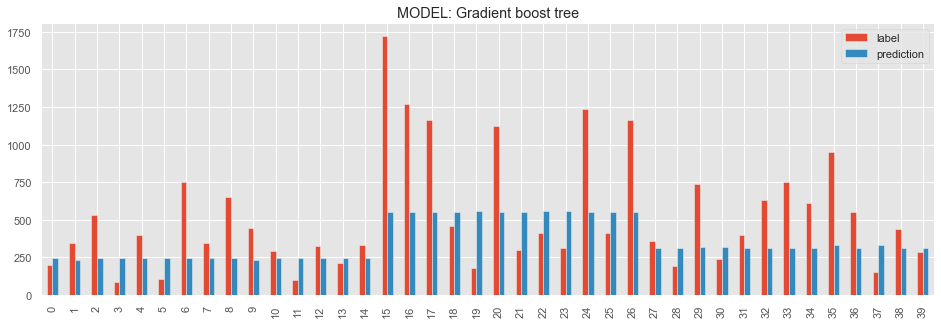

<Figure size 432x288 with 0 Axes>

In [24]:
y_true_all = gbt_predict.select("label").toPandas()
y_pred_all = gbt_predict.select("prediction").toPandas()
plot_real_vs_pred("Gradient boost tree", y_true_all, y_pred_all, "../plots/true_pred.png")

In [25]:
gbt_predict.filter(abs(col("error")) <= 100).count()

1272263

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

tmp = train_agg.toPandas()

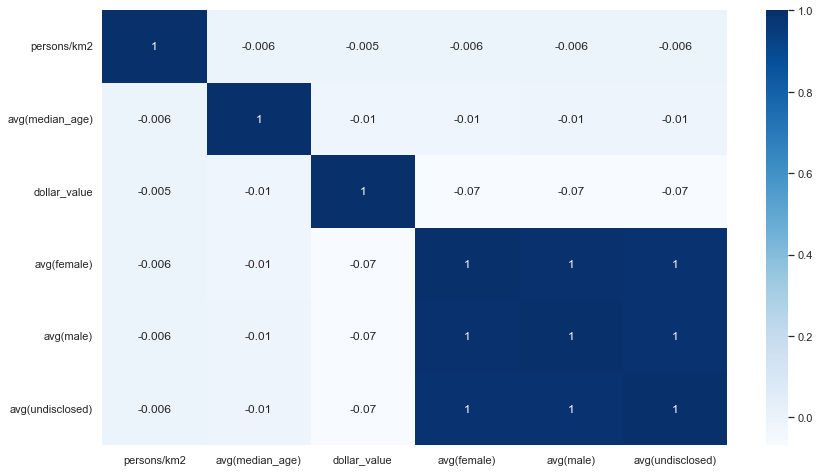

In [27]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = tmp.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

heatmap.get_figure().savefig("../plots/corr_final.png")

In [28]:
corr.dollar_value

persons/km2        -0.004712
avg(median_age)    -0.014848
dollar_value        1.000000
avg(female)        -0.068685
avg(male)          -0.067800
avg(undisclosed)   -0.068960
Name: dollar_value, dtype: float64